In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import torch
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pathlib import Path

from utils import load_IDMapping, load_train_data, print_pykeen_metrics, calc_classi_metrics, save_embeddings

source_dir = "../data/dataset"
train_res = "./tmp"

current_time = datetime.now().strftime('%Y%m%d-%H%M%S')
print(f"Current time: {current_time}")

columns = ['head', 'relation', 'tail']
entity2id, relation2id = load_IDMapping(source_dir)
support_triplet = pd.read_csv(source_dir + "/support_triplet.tsv", sep='\t', names=columns)
print(f" num_support_triplets: {len(support_triplet)}")

train_data, test_data, train_data_id, test_data_id = load_train_data(source_dir, entity2id, relation2id, 0)
train_data_pos = train_data[train_data['label'] == 1]
train_data_pos = train_data_pos[columns]

emb_graph = pd.concat([train_data_pos, support_triplet], ignore_index=True)

# Create a TriplesFactory from the DataFrame
emb_triplet = TriplesFactory.from_labeled_triples(emb_graph[columns].values, entity_to_id=entity2id, relation_to_id=relation2id, create_inverse_triples=True)
emb_trainning, emb_testing, emb_validation = emb_triplet.split([0.8, 0.1, 0.1])
print(f" num_emb_triplets: {emb_triplet.num_triples}")
print(f" emb_train_triplets: {emb_trainning.num_triples}, emb_test_triplets: {emb_testing.num_triples}, emb_valid_triplets: {emb_validation.num_triples}")

test_data_tf = TriplesFactory.from_labeled_triples(test_data[columns].values, entity_to_id=entity2id, relation_to_id=relation2id, create_inverse_triples=False)

# Create a model

/home/worker/software/anaconda3/envs/pykeen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current time: 20250219-153853
 num_entity: 945552
 num_relation: 126
 num_support_triplets: 20930149
Load data from ../data/dataset and 1 fold:
 num_train_triples: 1879648
 num_test_triples: 469912


using automatically assigned random_state=1826428817


 num_emb_triplets: 22809797
 emb_train_triplets: 18247837, emb_test_triplets: 2280980, emb_valid_triplets: 2280980


In [2]:
model = 'ConvE'
proj_name = f"{model}_{current_time}"

pipeline_result = pipeline(
    random_seed=42,
    model=model,
    model_kwargs=dict(
        embedding_dim=100,
    ),

    training=emb_trainning,
    testing=emb_testing,
    validation=emb_validation,

    training_loop='sLCWA',
    training_kwargs=dict(
        num_epochs=2,
        batch_size=10000,
        use_tqdm_batch=False,
        # checkpoint_name=f'{proj_name}_checkpoint.pt',
        # checkpoint_directory='./tmp',
        # checkpoint_frequency=3,
        # checkpoint_on_failure=True,
        # sampler="schlichtkrull",
    ),
    
    # optimizer='Adam',
    # optimizer_kwargs=dict(
    #     lr=0.001,
    # ),

    negative_sampler='bernoulli',
    negative_sampler_kwargs=dict(
        num_negs_per_pos=1,
    ),

    evaluator='RankBasedEvaluator',
    evaluator_kwargs=dict(
        filtered=True,
    ),
    
    # stopper='early',
    # stopper_kwargs=dict(
    #     frequency=3,
    #     patience=2,
    #     relative_delta=0.005,
    #     best_model_path=Path(f'./tmp/{proj_name}_best-model-weights.pt'),
    # ),

    device=torch.device("cuda:1"),
    # result_tracker='tensorboard',
    # result_tracker_kwargs=dict(
    #     experiment_path=f'tb_logs/{proj_name}',
    # ),
)
# pipeline_result.save_to_directory(f'tmp/{proj_name}')
my_pykeen_model = pipeline_result.model
# print_pykeen_metrics(pipeline_result, test_data_tf, test_data, emb_trainning, emb_testing, emb_validation)

# save_embeddings(my_pykeen_model, f'tmp/{proj_name}')

INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cuda:1:   0%|          | 0/2 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/3649 (0.03%) batches).
Training epochs on cuda:1: 100%|██████████| 2/2 [12:16<00:00, 368.18s/epoch, loss=0.0107, prev_loss=0.13]
Evaluating on cuda:1: 100%|██████████| 2.28M/2.28M [3:12:32<00:00, 197triple/s]  
INFO:pykeen.evaluation.evaluator:Evaluation took 11618.17s seconds


In [5]:
import torch
import numpy as np
from pykeen.constants import PYKEEN_CHECKPOINTS
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.models import RESCAL
from pykeen.models import ConvE
from pykeen.models import TransE

# my_model = ConvE(triples_factory=emb_trainning, embedding_dim=100)
# checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath(f"/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/checkpoints/baseline/ConvE_20250114-094927_checkpoint.pt"))
# my_model = RESCAL(triples_factory=emb_trainning, embedding_dim=100)
# checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath(f"/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/checkpoints/baseline/RESCAL_20250117-214900_checkpoint.pt"))
my_model = TransE(triples_factory=emb_trainning, embedding_dim=100)
checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath(f"/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/checkpoints/baseline/TransE_20250109-215115_checkpoint.pt"))
my_model.load_state_dict(checkpoint['model_state_dict'])
checkpoint['optimizer_state_dict']['param_groups']

No random seed is specified. This may lead to non-reproducible results.


[{'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None,
  'params': [0, 1]}]

In [2]:
import torch

device = torch.device(f"cuda:{3}" if torch.cuda.is_available() else "cpu")
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/CompGCN_20250109-215102/trained_model.pkl", map_location='cpu')
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/TransE_20250109-215115/trained_model.pkl", map_location='cpu')
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/TransR_20250109-215206/trained_model.pkl", map_location='cpu')
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/RotatE_20250109-215430/trained_model.pkl", map_location='cpu')
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/DistMult_20250111-102406/trained_model.pkl", map_location='cpu')
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/ComplEx_20250111-102451/trained_model.pkl", map_location='cpu')
# my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/RESCAL_20250117-214900/trained_model.pkl", map_location='cpu')
my_model = torch.load("/home/worker/users/ZC/KnowledgeGraph/TarKG_reason/pykeen_model/train_results/baseline/ConvE_20250124-172107/trained_model.pkl", map_location='cuda:3')
# my_model = my_model.to(device)

In [3]:
from utils import load_gene_disease_ids
from pykeen.evaluation import RankBasedEvaluator

gd_ent = []
gd_rel = []
for key, value in entity2id.items():
    if key.startswith("Disease") or key.startswith("Gene"):
        gd_ent.append(value)
for key, value in relation2id.items():
    if key.startswith("Disease:Gene") or key.startswith("Gene:Disease"):
        gd_rel.append(value)

In [ ]:
evaluator = RankBasedEvaluator()
test_results = evaluator.evaluate(
    model=my_model,
    mapped_triples=test_data_tf.mapped_triples,
    restrict_entities_to=gd_ent,
    restrict_relations_to=gd_rel,
    # additional_filter_triples=[
    #     emb_trainning.mapped_triples,
    #     emb_validation.mapped_triples,
    #     emb_testing.mapped_triples,
    # ],
    use_tqdm=True,
)

print(f"Hits@1-subGD={test_results.get_metric('hits@1'):.4f}")
print(f"Hits@3-subGD={test_results.get_metric('hits@3'):.4f}")
print(f"Hits@10-subGD={test_results.get_metric('hits@10'):.4f}")
print(f"MRR-subGD={test_results.get_metric('mean_reciprocal_rank'):.4f}")
print(f"MR-subGD={test_results.get_metric('mean_rank'):.4f}\n")

The filtered setting was enabled, but there were no `additional_filter_triples`
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filter_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filter_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]

Evaluating on cuda:1:   0%|          | 0.00/940k [00:00<?, ?triple/s]/home/worker/software/anaconda3/envs/pykeen/lib/python3.9/site-packages/pykeen/evaluation/evaluator.py:388: UserWarning: Encountered type(value)=<class 'list'> which cannot be hashed
  return evaluate(
Evaluating on cuda:1: 100%|██████████| 940k/940k [55:49<00:00, 281triple/s]  

Hits@1-subGD=0.0023
Hits@3-subGD=0.0050
Hits@10-subGD=0.0149
MRR-subGD=0.0078
MR-subGD=11912.1650



## 分类指标

In [3]:
from pykeen import predict
score_df = predict.predict_triples(
    model=my_model,
    triples=test_data,
    triples_factory=emb_trainning,
)
score_df

Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).


ScorePack(result=tensor([[     0,      0,  30086],
        [     0,      0,  31753],
        [     0,      0,  32770],
        ...,
        [178197,      9,  12906],
        [178200,      6,   7714],
        [178202,      9,  12906]]), scores=tensor([ 1.2518, -0.5360,  0.7804,  ...,  4.3877,  3.4541,  4.6173],
       device='cuda:3'))

In [4]:
# test_data_triplet =test_data_tf.triples
# print(test_data_triplet.shape)
# score = my_model.predict_hrt(test_data_tf.mapped_triples).sigmoid().detach().cpu().numpy() #
# score

# test_data_triplet = score_df.result.detach().cpu().numpy()
test_data_triplet =test_data_tf.triples
score = score_df.scores.sigmoid().detach().cpu().numpy()
score

Reconstructing all label-based triples. This is expensive and rarely needed.


array([0.7776172 , 0.36910963, 0.68576497, ..., 0.987723  , 0.9693524 ,
       0.9902171 ], dtype=float32)

In [5]:
test_data_score = pd.DataFrame(np.concatenate([test_data_triplet, score.reshape(-1, 1)], axis=1), columns=['head', 'relation', 'tail', 'score'])
test_data_label_score = pd.merge(test_data, test_data_score, on=['head', 'relation', 'tail'], how='inner')
test_data_label_score

,head,relation,tail,label,score
0,Disease::DOID:0001816,Disease:Gene::associated with,Gene::A0A8C0T7K1,1,0.68576497
1,Disease::DOID:0001816,Disease:Gene::associated with,Gene::A0A8I3PN58,1,0.66807336
2,Disease::DOID:0001816,Disease:Gene::associated with,Gene::B2RU80,1,0.8270892
3,Disease::DOID:0001816,Disease:Gene::associated with,Gene::O15554,1,0.89099896
4,Disease::DOID:0001816,Disease:Gene::associated with,Gene::O35462,1,0.74652475
...,...,...,...,...,...
939819,Gene::Q9Z2Y9,Gene:Disease::role in pathogenesis,Disease::MESH:D000094627,0,0.91772854
939820,Gene::W0UUZ5,Gene:Disease::role in pathogenesis,Disease::DOID:7551,0,0.9532816
939821,Gene::W0UUZ5,Gene:Disease::role in pathogenesis,Disease::DOID:0060614,0,0.83195055
939822,Gene::P01215,Gene:Disease::role in pathogenesis,Disease::MESH:D064420,0,0.9948236


In [6]:
y = test_data_label_score['label'].astype(float).values
pred = test_data_label_score['score'].astype(float).values

from sklearn import metrics
def roc_auc(y, pred):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

def pr_auc(y, pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y, pred)
    pr_auc = metrics.auc(recall, precision)
    return pr_auc

roc = roc_auc(y, pred)
pr = pr_auc(y, pred)

# 计算 Accuracy
# threshold = 0.5  # 预测标签，阈值设为 0.5
threshold = np.percentile(score, 50)  # 使用分数的中位数作为阈值
# threshold = np.mean(score)  # 使用分数的平均值作为阈值
print(threshold)
preds = (pred > threshold).astype(int)

acc = metrics.accuracy_score(y, preds)

print(f'ROC AUC: {roc:.4f}, PR AUC: {pr:.4f}, Accuracy: {acc:.4f}')

# test_data_label_score.to_csv('./tmp/test_data_label_score.csv', index=False)
# preds

0.8748684525489807
ROC AUC: 0.5068, PR AUC: 0.4884, Accuracy: 0.4925


In [7]:
test_data_label_score[['label', 'score']].to_csv('./train_results/baseline/ConvE_scores.csv', index=False, header=False)

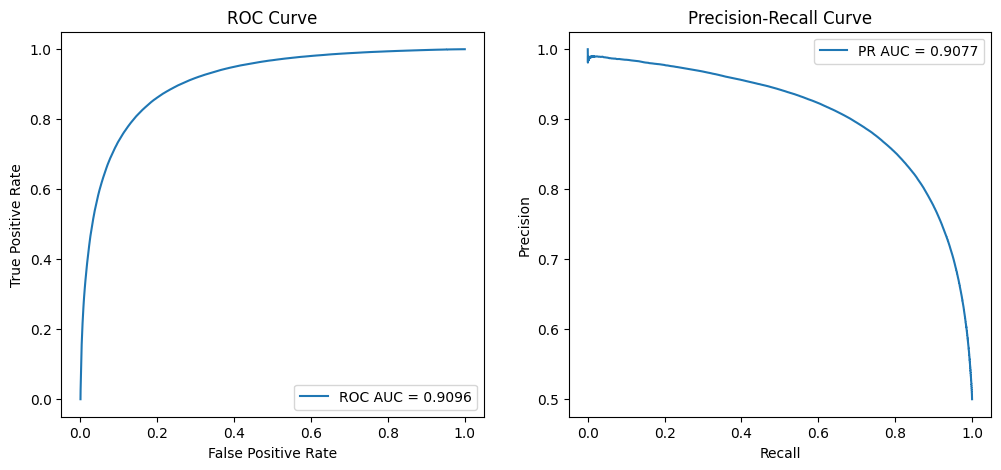

In [11]:
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(y, pred)
precision, recall, _ = metrics.precision_recall_curve(y, pred)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {metrics.auc(fpr, tpr):.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {metrics.auc(recall, precision):.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()

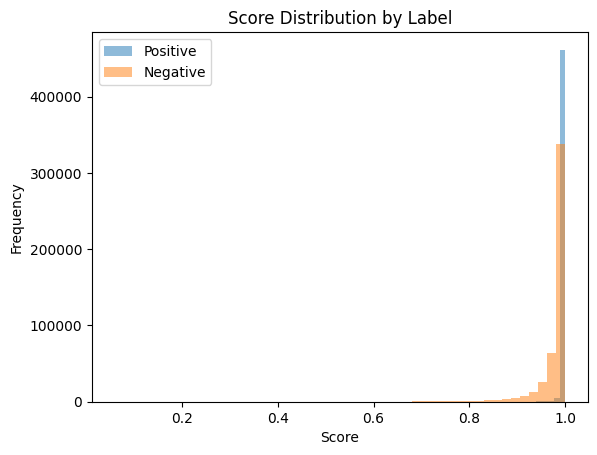

In [12]:
plt.hist(pred[y == 1], bins=50, alpha=0.5, label='Positive')
plt.hist(pred[y == 0], bins=50, alpha=0.5, label='Negative')
plt.legend()
plt.title('Score Distribution by Label')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()